In [1]:
from oggm import cfg
from oggm import tasks, utils, workflow, graphics
from oggm.core import massbalance
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import igm

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

## Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

## Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)

## Pick a glacier
# rgi_ids = ['RGI60-11.01450']  # This is Aletsch
# rgi_ids = ['RGI60-11.00897']  # This is Hintereisferner
rgi_ids = ['RGI60-11.03638']  # This is Argentiere
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/exps/igm_v2'

gdir = workflow.init_glacier_directories(rgi_ids, prepro_base_url=base_url, from_prepro_level=3, prepro_border=40)[0]


2024-05-29 22:56:20: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-05-29 22:56:20: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-05-29 22:56:20: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-05-29 22:56:21: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2024-05-29 22:56:21: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [2]:
# ### Recalibrate OGGM to match fixed geometry MB from hugonnet
# The default in OGGM nowadays is to match Hugonnet within a dynamical spinup. Lets do that here:

# 1D - flowline-approach
# massbalance.mb_calibration_from_geodetic_mb(gdir, overwrite_gdir=True, informed_threestep=True)
# output for comparison
# one_d = gdir.read_json('mb_calib')

In [3]:
# 2D - gridded-approach
massbalance.mb_calibration_from_geodetic_mb(gdir, overwrite_gdir=True, mb_2d=True, informed_threestep=True)
# output for comparison
two_d = gdir.read_json('mb_calib')


In [4]:
# ### Recompute the volume to match Farinotti et al. 2019 (for consistency with IGM later) 
from oggm.global_tasks import calibrate_inversion_from_consensus
calibrate_inversion_from_consensus([gdir])
# get ready for modelling
tasks.init_present_time_glacier(gdir)

# ### Experiment: a random warming simulation
# I recommend to stick to simple experiments for now. Here is a random run based on the climate of the past 21 years

# Do a random run with a bit of warming
tasks.run_random_climate(gdir, nyears=100, 
                         y0=2009, halfsize=10, # Climate of 1999-2019
                         seed=1,  # Change for another randomness 
                         temperature_bias=0,  # casual warming - change for other scenarios
                         store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                         output_filesuffix='_rdn_1',  # name the run
                        );

2024-05-29 22:56:21: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2024-05-29 22:56:22: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2024-05-29 22:56:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-05-29 22:56:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-05-29 22:56:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-05-29 22:56:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-05-29 22:56:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2024-05-29 22:56:22: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2024-05-29 22:56:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-05-29 22:56:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-05-29 22:56:22: oggm.workflow: Execute

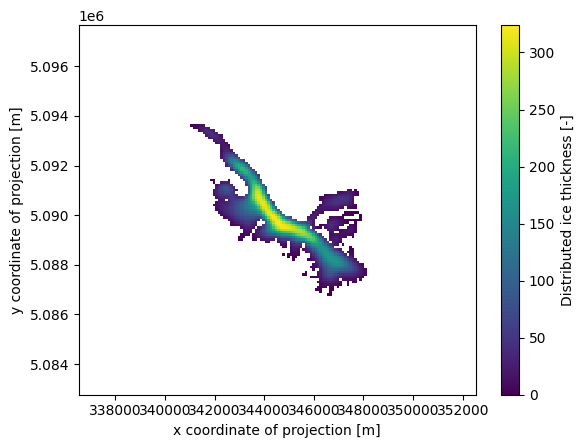

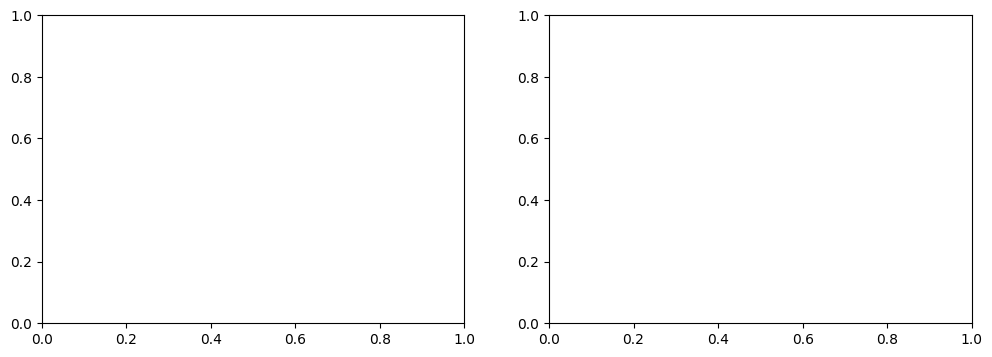

In [5]:
# ## Redistribute: preprocessing
# The required tasks can be found in the `distribute_2d` module of the sandbox:
from oggm.sandbox import distribute_2d

# This is to add a new topography to the file (smoothed differently)
distribute_2d.add_smoothed_glacier_topo(gdir)
# This is to get the bed map at the start of the simulation
tasks.distribute_thickness_per_altitude(gdir)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
distribute_2d.assign_points_to_band(gdir)
# Let's have a look at what we just did:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

# Inititial glacier thickness
f, ax = plt.subplots()
ds.distributed_thickness.plot(ax=ax);
ax.axis('equal');

# Which points belongs to which band, and then within one band which are the first to melt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# ds.band_index.rio.to_raster("/mnt/c/Users/kneibm/Documents/CAIRN/Accu_Argentiere/argentiere_pleiades_smb/output/flowline/flowline_oggm.tif")
ds.band_index.rio.to_raster("flowline_oggm.tif")


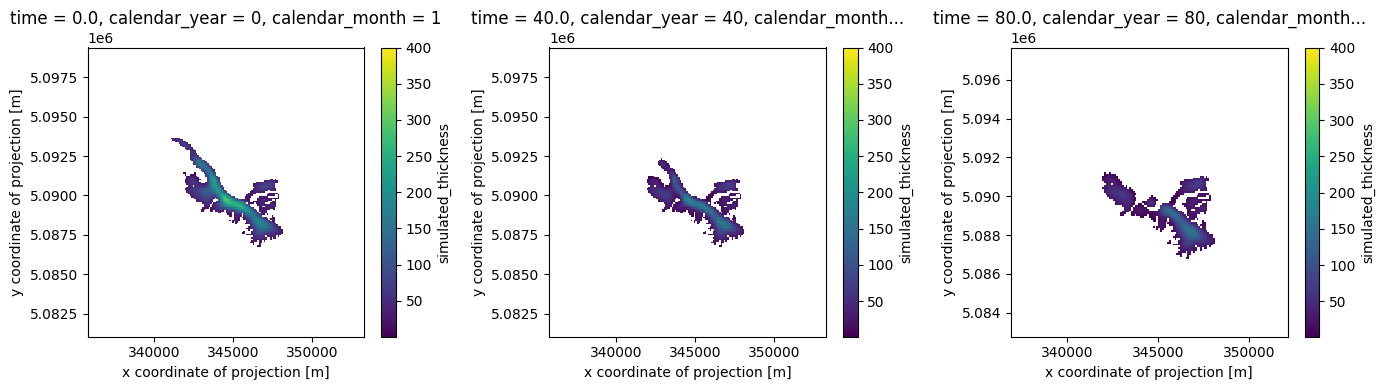

In [6]:
# ## Redistribute simulation
# The tasks above need to be run only once. The next one however should be done for each simulation:
distribute_2d.distribute_thickness_from_simulation(gdir, input_filesuffix='_rdn_1')

# ## Plot 
with xr.open_dataset(gdir.get_filepath('gridded_simulation', filesuffix='_rdn_1')) as ds:
    ds = ds.load()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
# ds.distributed_thickness.sel(time=0).plot(ax=ax1, vmax=400);
# ds.distributed_thickness.sel(time=40).plot(ax=ax2, vmax=400);
# ds.distributed_thickness.sel(time=80).plot(ax=ax3, vmax=400);
ds.simulated_thickness.sel(time=0).plot(ax=ax1, vmax=400);
ds.simulated_thickness.sel(time=40).plot(ax=ax2, vmax=400);
ds.simulated_thickness.sel(time=80).plot(ax=ax3, vmax=400);
ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();

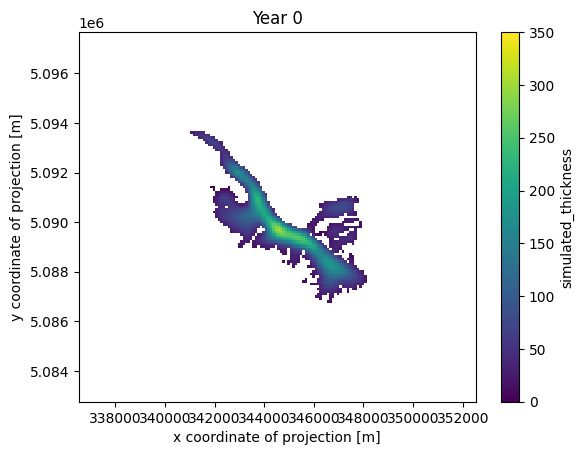

In [7]:
# ## Animation!
from matplotlib import animation
from IPython.display import HTML, display

# Get a handle on the figure and the axes
fig, ax = plt.subplots()
thk = ds['simulated_thickness']

# Plot the initial frame. 
cax = thk.isel(time=0).plot(ax=ax,
    add_colorbar=True,
    cmap='viridis',
    vmin=0, vmax=350,
    cbar_kwargs={
        'extend':'neither'
    }
)
ax.axis('equal')

def animate(frame):
    ax.set_title(f'Year {int(frame)}')
    cax.set_array(thk.values[frame, :].flatten())

ani_glacier = animation.FuncAnimation(fig, animate, frames=len(thk.time), interval=200);


In [8]:
HTML(ani_glacier.to_jshtml())

# Write to mp4?
# FFwriter = animation.FFMpegWriter(fps=10)
# ani2.save('animation.mp4', writer=FFwriter)

In [9]:
# ## Understand the calibration of the MB model 
# The MB model is trained to reproduce the MB seen by Hugonnet et al on a fixed glacier geometry. Lets check it:
mb_model = massbalance.MonthlyTIModel(gdir)

# This is just a utility
heights, widths = gdir.get_inversion_flowline_hw()

years = np.arange(2000, 2020)
mbts = pd.DataFrame(index=years)
for y in years:
    mb_on_h = mb_model.get_annual_mb(heights, year=y)
    mbts.loc[y, 'mb_1d'] = np.average(mb_on_h, weights=widths) * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density']

mbts.mean() 


mb_1d   -1092.688481
dtype: float64

In [10]:
fp = gdir.get_filepath('gridded_data')
with xr.open_dataset(fp) as gd:
    _heights = np.where(gd.glacier_mask, gd.topo_smoothed, np.nan).flatten()
    heights =_heights[~np.isnan(_heights)]
    widths = np.ones(len(heights))

years = np.arange(2000, 2020)
mbts = pd.DataFrame(index=years)
for y in years:
    mb_on_h = mb_model.get_annual_mb(heights, year=y)
    mbts.loc[y, 'mb_2d'] = np.average(mb_on_h, weights=widths) * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density']

mbts.mean() 

mb_2d   -1049.4
dtype: float64

In [11]:
# Get the reference data
ref_mb_df = massbalance.get_geodetic_mb_dataframe().loc[gdir.rgi_id]
ref_mb_df = ref_mb_df.loc[ref_mb_df['period'] == '2000-01-01_2020-01-01']
# dmdtda: in meters water-equivalent per year -> we convert to kg m-2 yr-1
ref_mb = ref_mb_df['dmdtda'].iloc[0] * 1000
ref_mb_err = ref_mb_df['err_dmdtda'].iloc[0] * 1000

ref_mb, ref_mb_err


(-1049.4, 166.8)

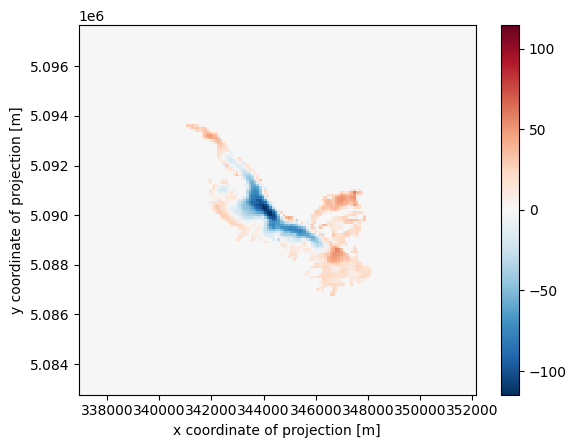

In [12]:

# It's not far (that's good), so we try without recalibration:

# plot difference between the 2 bedrocks
bed = gd.topo_smoothed - gd.distributed_thickness.fillna(0)
bed_con_smoothed = gd.topo_smoothed - gd.consensus_ice_thickness.fillna(0) 

bed_diff = bed-bed_con_smoothed

bed_diff.plot(); # comparison plot between distributed thickness and consensus_ice_thickness bed. 
# positive values: OGGM distributed thickness is thicker

# does it even make sense to use the smoothed topo and the consensus_ice_thickness to define the bed? 
# => with 'topo' the spread in the final comparison graph(last cell) is less pronounced than with 'topo_smoothed' (using 'bed_con_smoothed')
bed_con = gd.topo - gd.consensus_ice_thickness.fillna(0) 



In [13]:
mb = massbalance.RandomMassBalance(gdir,
                                   y0=2009, halfsize=10, # Climate of 1999-2019
                                   seed=1,  # Change for another randomness 
                                   )
mb.temp_bias += 0  # casual warming

In [14]:
############################### OGGM-IGM
from igm.instructed_oggm import IGM_Model2D

sdmodel_igm = IGM_Model2D(bed.values, init_ice_thick=gd.distributed_thickness.fillna(0).values, 
                     dx=gdir.grid.dx, dy=gdir.grid.dy, x=bed.x, y=bed.y, mb_model=mb, 
                        y0=0., mb_filter=gd.glacier_mask.values==1)

dsr_igm = sdmodel_igm.run_until_and_store(100, grid=gdir.grid)





2024-05-29 22:56:31.834343: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-29 22:56:31.834374: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-29 22:56:31.834384: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-29 22:56:31.834424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-29 22:56:31.834440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found pretrained emulator in the igm package: pinnbp_10_4_cnn_16_32_2_1


/Users/afisc/igm_venv/lib/python3.10/site-packages/tensorflow/python/framework/tensor_util.py:518: RuntimeWarning: overflow encountered in cast
  nparray = np.array(values, dtype=np_dt)
2024-05-29 22:56:33.996901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


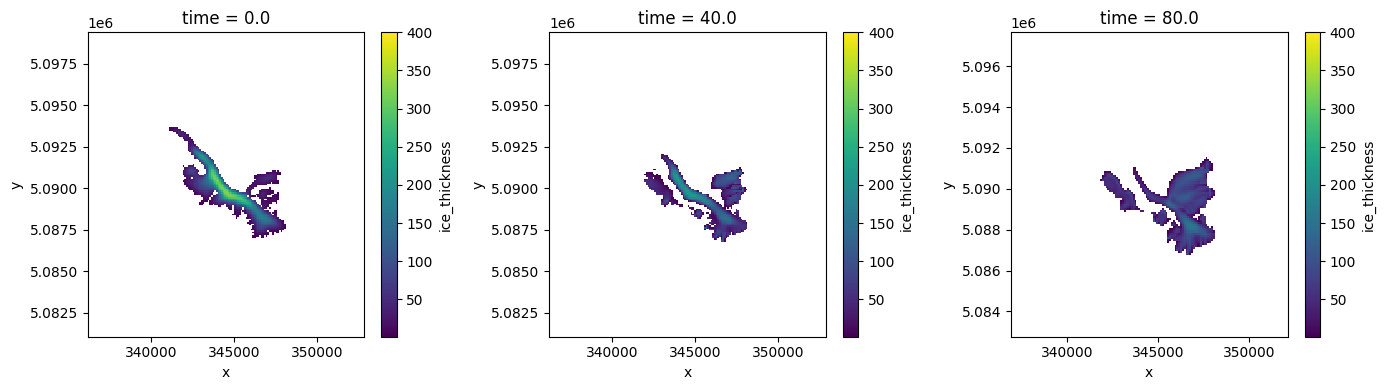

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
dsr_igm.where(dsr_igm['ice_thickness'] > 1).ice_thickness.sel(time=0).plot(ax=ax1, vmax=400);
dsr_igm.where(dsr_igm['ice_thickness'] > 1).ice_thickness.sel(time=40).plot(ax=ax2, vmax=400);
dsr_igm.where(dsr_igm['ice_thickness'] > 1).ice_thickness.sel(time=80).plot(ax=ax3, vmax=400);
ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();

In [16]:
############################### OGGM-IGM
from igm.instructed_oggm import IGM_Model2D

sdmodel_igm_con = IGM_Model2D(bed_con.values, init_ice_thick=gd.consensus_ice_thickness.fillna(0).values, 
                     dx=gdir.grid.dx, dy=gdir.grid.dy, x=bed_con.x, y=bed_con.y, mb_model=mb, 
                        y0=0., mb_filter=gd.glacier_mask.values==1)

dsr_igm_con = sdmodel_igm_con.run_until_and_store(100, grid=gdir.grid)

Found pretrained emulator in the igm package: pinnbp_10_4_cnn_16_32_2_1


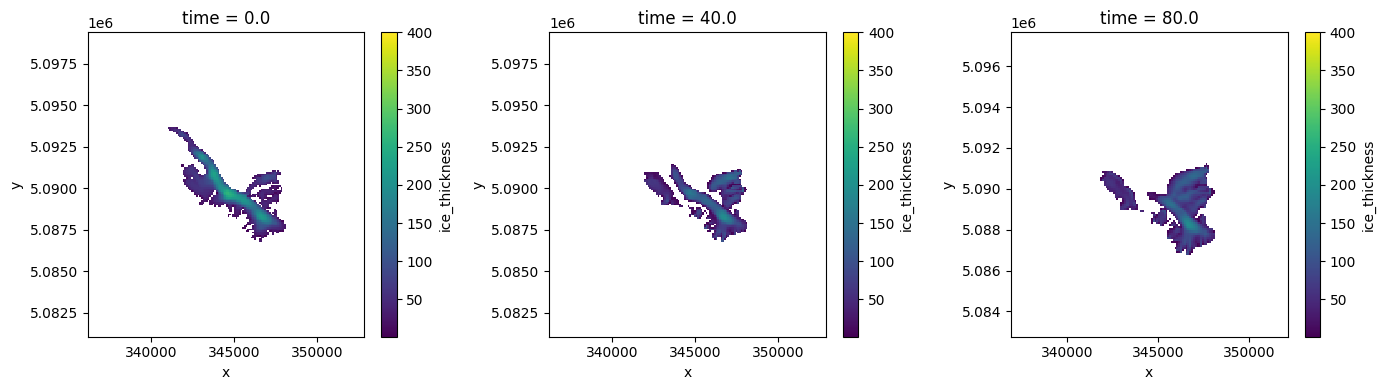

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
dsr_igm_con.where(dsr_igm_con['ice_thickness'] > 1).ice_thickness.sel(time=0).plot(ax=ax1, vmax=400);
dsr_igm_con.where(dsr_igm_con['ice_thickness'] > 1).ice_thickness.sel(time=40).plot(ax=ax2, vmax=400);
dsr_igm_con.where(dsr_igm_con['ice_thickness'] > 1).ice_thickness.sel(time=80).plot(ax=ax3, vmax=400);
ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();

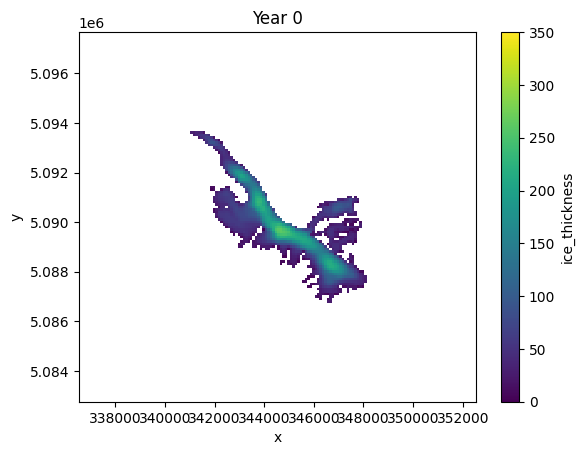

In [18]:
### Animation! 
fig, ax = plt.subplots()
thk_igm_con = dsr_igm_con['ice_thickness'].where(dsr_igm_con['ice_thickness'] > 1) # Maybe larger than 1 do avoid random years regrowth?

# Plot the initial frame. 
cax = thk_igm_con.isel(time=0).plot(ax=ax,
    add_colorbar=True,
    cmap='viridis',
    vmin=0, vmax=350,
    cbar_kwargs={
        'extend':'neither'
    }
)
ax.axis('equal')

def animate(frame):
    ax.set_title(f'Year {int(frame)}')
    cax.set_array(thk_igm_con.values[frame, :].flatten())

ani_glacier = animation.FuncAnimation(fig, animate, frames=len(thk_igm_con.time), interval=200);


In [19]:
HTML(ani_glacier.to_jshtml())

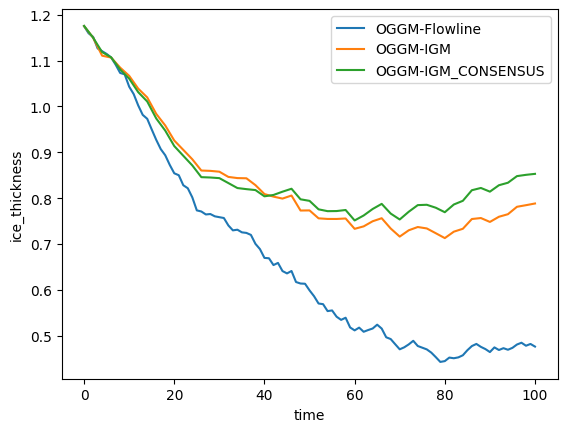

In [20]:
# comparison plots

(ds.simulated_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-Flowline');
(dsr_igm.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM');
(dsr_igm_con.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM_CONSENSUS');

plt.legend();

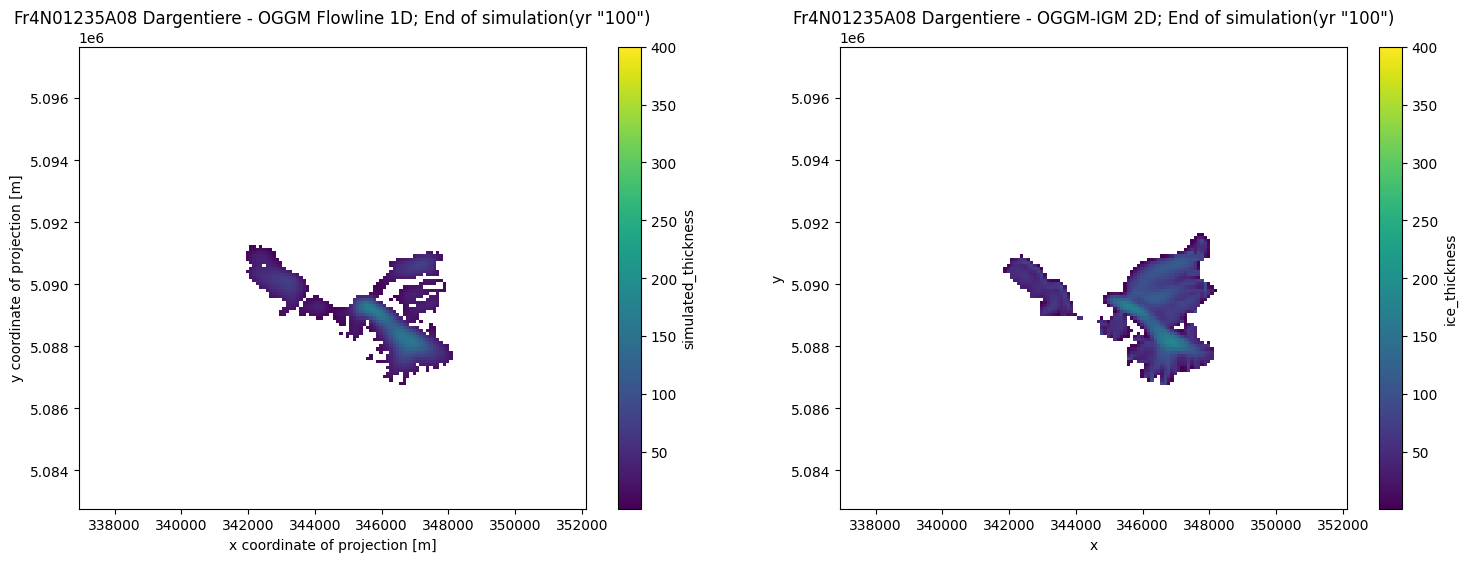

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ds.simulated_thickness.sel(time=100).plot(ax=ax1, vmax=400);
ax1.set_title(f'{gdir.name} - OGGM Flowline 1D; End of simulation(yr \"100\")')
dsr_igm.where(dsr_igm['ice_thickness'] > 1).ice_thickness.sel(time=100).plot(ax=ax2, vmax=400);
ax2.set_title(f'{gdir.name} - OGGM-IGM 2D; End of simulation(yr \"100\")');

In [22]:
fig.savefig('argentiere_OGGMFlowline_OGGM-IGM_comparison.png')